In [3]:
# Import required packages
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Import the dataset
df = pd.read_csv("winequality-red.csv", sep = ';')

In [5]:
# Split the whole dataset into training, validation and test subsets
train_ds = df.sample(frac=0.7, random_state=200)
df_new = df.drop(train_ds.index)
valid_ds = df_new.sample(frac=0.5, random_state=200)
test_ds = df_new.drop(valid_ds.index)

In [6]:
print(train_ds)

      fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
366            12.8             0.615         0.66  ...       0.73     10.0        7
1325            6.7             0.460         0.24  ...       0.60     10.6        6
133             6.6             0.500         0.01  ...       0.58      9.8        6
1418            7.8             0.530         0.01  ...       0.46      9.8        5
1258            6.8             0.640         0.00  ...       0.63     11.3        6
...             ...               ...          ...  ...        ...      ...      ...
1386            7.4             0.640         0.07  ...       0.58      9.6        5
721             8.9             0.480         0.24  ...       0.53      9.2        5
267             7.9             0.350         0.46  ...       0.86     12.8        8
1543           11.1             0.440         0.42  ...       0.57     10.4        6
1593            6.8             0.620         0.08  ...       0.8

In [8]:
# Compute median for the quality column
data_set = (df-df.min())/(df.max()-df.min())
median = data_set[["quality"]].median()
print(median)

quality    0.6
dtype: float64


In [9]:
# Function for turning all values equal or greater than median into 1
def make_binary(target):
  if target >= median:
    return 1
  else: return 0

In [10]:
# Data pipeline for training subset
# Separate labels from inputs
train_inputs = train_ds.drop('quality', axis=1)
train_labels = train_ds[['quality']]

# Build a Tensorflow Dataset
train_input = tf.data.Dataset.from_tensor_slices(train_inputs)
train_label = tf.data.Dataset.from_tensor_slices(train_labels)
train_label = train_label.map(make_binary)
train_ds = tf.data.Dataset.zip((train_input, train_label))

train_ds = train_ds.shuffle(1000).batch(8).prefetch(20)

In [14]:
# Data pipeline for validation subset
# Separate labels from inputs
valid_inputs = valid_ds.drop('quality', axis=1)
valid_labels = valid_ds[['quality']]

# Build a Tensorflow Dataset
valid_input = tf.data.Dataset.from_tensor_slices(valid_inputs)
valid_label = tf.data.Dataset.from_tensor_slices(valid_labels)
valid_label = valid_label.map(make_binary)
valid_ds = tf.data.Dataset.zip((valid_input, valid_label))

valid_ds = valid_ds.shuffle(1000).batch(8).prefetch(20)

AttributeError: ignored

In [15]:
# Data pipeline for test subset
# Separate labels from inputs
test_inputs = test_ds.drop('quality', axis=1)
test_labels = test_ds[['quality']]

# Build a Tensorflow Dataset
test_input = tf.data.Dataset.from_tensor_slices(test_inputs)
test_label = tf.data.Dataset.from_tensor_slices(test_labels)
test_label = test_label.map(make_binary)
test_ds = tf.data.Dataset.zip((test_input, test_label))

test_ds = test_ds.shuffle(1000).batch(8).prefetch(20)

In [175]:
# Custom Model
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        regularizer = tf.keras.regularizers.L1(l1=0.01)

        self.dense1 = tf.keras.layers.Dense(190, 
                                            activation = tf.nn.sigmoid,
                                            kernel_regularizer=regularizer)
        self.dense2 = tf.keras.layers.Dense(190, 
                                            activation = tf.nn.sigmoid,
                                            kernel_regularizer=regularizer)
        self.out = tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,
                                         kernel_regularizer=regularizer)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        out = self.out(x)
        return out



# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [176]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    #sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.round(target, 0) == np.round(prediction, 0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [177]:
#tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.4955357142857143
Epoch: 1 starting with accuracy 0.5044642857142857
Epoch: 2 starting with accuracy 0.5094866071428572
Epoch: 3 starting with accuracy 0.5597098214285714
Epoch: 4 starting with accuracy 0.5390625
Epoch: 5 starting with accuracy 0.5803571428571428
Epoch: 6 starting with accuracy 0.5122767857142857
Epoch: 7 starting with accuracy 0.5446428571428572
Epoch: 8 starting with accuracy 0.52734375
Epoch: 9 starting with accuracy 0.5345982142857143


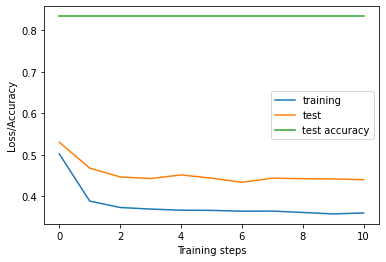

In [133]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()